In [10]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch
from src.dataset import CellDataset
from easydict import EasyDict
from dotenv import load_dotenv
from src.augmentations import train_transform
from pytorch_toolbelt.utils import set_manual_seed
from src.postprocessing import postprocess_predictions
from src.iou_metric import iou_map

current_dir = Path("..")

load_dotenv()
set_manual_seed(0)

Using manual seed: 0


In [11]:
plt.rcParams["figure.figsize"] = (8, 8)

weights_path = current_dir / "weights" / "maxim_baseline.ckpt"
assert weights_path.is_file(), f"File not found: {weights_path.absolute()}"

config = EasyDict(
    dataset_path=Path(os.environ['dataset_path']),
    val_size=0.2,
    device='cpu'
)

device = config.device

In [12]:
dataset = CellDataset(cfg=config, transform=train_transform, mode='train')
image, target = dataset[10]
true_masks = target['masks']

print(image.size())
print(true_masks.size())

true_masks = true_masks.cpu().int().numpy()



torch.Size([1, 520, 704])
torch.Size([536, 520, 704])


In [13]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=2)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)
model.eval()
print()

In [14]:
image = image.to(device)

with torch.no_grad():
    outputs = model.forward([image])

prediction = postprocess_predictions(outputs=outputs, mask_threshold=0.5, score_threshold=0.4)[0]

pred_masks = prediction['masks']
print(pred_masks.shape)

(100, 520, 704)


In [15]:
def flatten_masks(masks: np.array):
    """Takes the array of binary masks, enumerates them and collect them in 2d mask"""
    pred = np.zeros_like(masks[0], dtype=np.int64)
    for ii, mask in enumerate(masks):
        pred[mask == 1] = ii + 1

    return pred

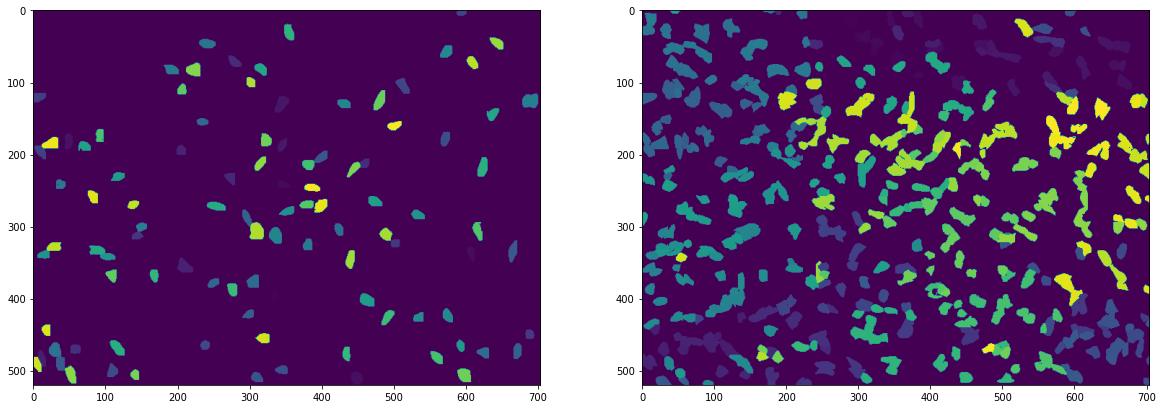

In [16]:
flatten_pred = flatten_masks(pred_masks)
flatten_true = flatten_masks(true_masks)


fig, axes = plt.subplots(ncols=2, figsize=(20, 20))
axes[0].imshow(flatten_pred)
axes[1].imshow(flatten_true)
plt.show()


In [17]:
%%timeit

iou_map(true_masks, pred_masks, verbose=0)

496 ms ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
iou_map(true_masks, pred_masks, verbose=0)

0.012546690677954483